In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from datetime import datetime
import seaborn as sns
%matplotlib inline

## Text Processing Case Study

In this example, we will apply string processing to the process of data cleaning and exploratory data analysis.

### Getting the Data

The city of Berkeley maintains an [Open Data Portal](https://data.cityofberkeley.info/) for citizens to access data about the city.  We will be examining [Call Data](https://data.cityofberkeley.info/Public-Safety/Berkeley-PD-Calls-for-Service/k2nh-s5h5).



In [3]:
calls = pd.read_csv('data/Berkeley_PD_-_Calls_for_Service.csv')
calls.head()

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State
0,18022300,DISTURBANCE,04/18/2018 12:00:00 AM,22:17,DISORDERLY CONDUCT,3,09/06/2018 03:30:12 AM,"OREGON STREET &amp; MCGEE AVE\r\nBerkeley, CA\...",OREGON STREET & MCGEE AVE,Berkeley,CA
1,18026683,THEFT MISD. (UNDER $950),05/09/2018 12:00:00 AM,21:25,LARCENY,3,09/06/2018 03:30:13 AM,"200 UNIVERSITY AVE\r\nBerkeley, CA\r\n(37.8655...",200 UNIVERSITY AVE,Berkeley,CA
2,18038550,THEFT MISD. (UNDER $950),05/18/2018 12:00:00 AM,20:00,LARCENY,5,09/06/2018 03:30:09 AM,"2200 MILVIA ST\r\nBerkeley, CA\r\n(37.868574, ...",2200 MILVIA ST,Berkeley,CA
3,18014810,BURGLARY AUTO,03/13/2018 12:00:00 AM,08:50,BURGLARY - VEHICLE,2,09/06/2018 03:30:08 AM,"1200 SIXTH ST\r\nBerkeley, CA\r\n(37.881142, -...",1200 SIXTH ST,Berkeley,CA
4,18018643,ALCOHOL OFFENSE,03/31/2018 12:00:00 AM,13:29,LIQUOR LAW VIOLATION,6,09/06/2018 03:30:11 AM,"CENTER STREET &amp; SHATTUCK AVE\r\nBerkeley, ...",CENTER STREET & SHATTUCK AVE,Berkeley,CA


How many records did we get?

In [4]:
len(calls)

3788

What does an example `Block_Location` value look like?

In [5]:
print(calls['Block_Location'].iloc[0])

OREGON STREET &amp; MCGEE AVE
Berkeley, CA
(37.856572, -122.275241)


### Preliminary observations on the data?

1. `EVENTDT` -- Contains the incorrect time
1. `EVENTTM` -- Contains the time in 24 hour format (What timezone?)
1. `CVDOW` -- Encodes the day of the week (see data documentation).
1. `InDbDate` -- Appears to be correctly formatted and appears pretty consistent in time.
1. **`Block_Location` -- a multi-line string that contains coordinates.**
1. `BLKADDR` -- Appears to be the address in `Block Location`.
1. `City` and `State` seem redundant given this is supposed to be the city of Berkeley dataset.

### Extracting locations

The block location contains geographic coordinates. Let's extract them.

In [6]:
calls['Block_Location'][0]

'OREGON STREET &amp; MCGEE AVE\r\nBerkeley, CA\r\n(37.856572, -122.275241)'

In [7]:
calls_lat_lon = (
    calls['Block_Location']
    .str.extract("\((\d+\.\d+)\, (-\d+\.\d+)\)")
)
calls_lat_lon.columns = ['Lat', 'Lon']
calls_lat_lon.head(10)

,Lat,Lon
0,37.856572,-122.275241
1,37.865511,-122.309967
2,37.868574,-122.270415
3,37.881142,-122.30191
4,37.870308,-122.26805
5,37.867176,-122.267802
6,37.891594,-122.264883
7,37.848812,-122.278043
8,37.879467,-122.261062
9,37.858433,-122.280183


How many records have missing values?

In [8]:
calls_lat_lon.isnull().sum()

Lat    159
Lon    159
dtype: int64

Examine the missing values.

In [9]:
calls[calls_lat_lon.isnull().any(axis=1)]['Block_Location'].head(10)

68                   400 OAKVALE AVE\r\nBerkeley, CA\r\n
70                      200 MENLO PL\r\nBerkeley, CA\r\n
79     UNIVERSITY AVENUE &amp; M L KING JR WAY\r\nBer...
111                    3000 BOISE ST\r\nBerkeley, CA\r\n
112    HEARST AVENUE &amp; SEVENTH ST\r\nBerkeley, CA...
156    WOOLSEY STREET &amp; ELLIS ST\r\nBerkeley, CA\r\n
230                   900 ACACIA AVE\r\nBerkeley, CA\r\n
231             2100 M L KING JR WAY\r\nBerkeley, CA\r\n
246             2900 M L KING JR WAY\r\nBerkeley, CA\r\n
255                   453 S. 17TH ST\r\nBerkeley, CA\r\n
Name: Block_Location, dtype: object

Join in the extracted values.

In [10]:
if 'Lat' not in calls.columns:
    calls = calls.merge(calls_lat_lon, left_index=True, right_index=True)
calls.head()

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Lat,Lon
0,18022300,DISTURBANCE,04/18/2018 12:00:00 AM,22:17,DISORDERLY CONDUCT,3,09/06/2018 03:30:12 AM,"OREGON STREET &amp; MCGEE AVE\r\nBerkeley, CA\...",OREGON STREET & MCGEE AVE,Berkeley,CA,37.856572,-122.275241
1,18026683,THEFT MISD. (UNDER $950),05/09/2018 12:00:00 AM,21:25,LARCENY,3,09/06/2018 03:30:13 AM,"200 UNIVERSITY AVE\r\nBerkeley, CA\r\n(37.8655...",200 UNIVERSITY AVE,Berkeley,CA,37.865511,-122.309967
2,18038550,THEFT MISD. (UNDER $950),05/18/2018 12:00:00 AM,20:00,LARCENY,5,09/06/2018 03:30:09 AM,"2200 MILVIA ST\r\nBerkeley, CA\r\n(37.868574, ...",2200 MILVIA ST,Berkeley,CA,37.868574,-122.270415
3,18014810,BURGLARY AUTO,03/13/2018 12:00:00 AM,08:50,BURGLARY - VEHICLE,2,09/06/2018 03:30:08 AM,"1200 SIXTH ST\r\nBerkeley, CA\r\n(37.881142, -...",1200 SIXTH ST,Berkeley,CA,37.881142,-122.30191
4,18018643,ALCOHOL OFFENSE,03/31/2018 12:00:00 AM,13:29,LIQUOR LAW VIOLATION,6,09/06/2018 03:30:11 AM,"CENTER STREET &amp; SHATTUCK AVE\r\nBerkeley, ...",CENTER STREET & SHATTUCK AVE,Berkeley,CA,37.870308,-122.26805


## Examining Location information

Let's examine the geographic data (latitude and longitude).  Recall that we had some missing values.  Let's look at the behavior of these missing values according to crime type.

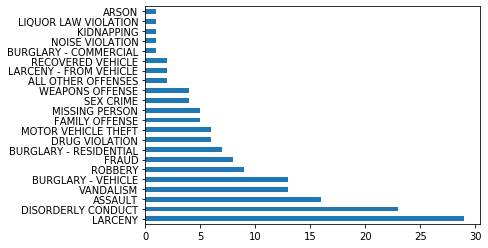

In [11]:
missing_lat_lon = calls[calls[['Lat', 'Lon']].isnull().any(axis=1)]
missing_lat_lon['CVLEGEND'].value_counts().plot(kind='barh');

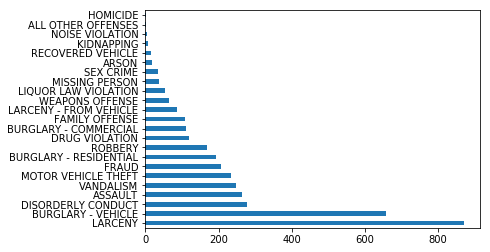

In [22]:
calls['CVLEGEND'].value_counts().plot(kind='barh');

### Observations?

There is a clear bias towards drug violations that is not present in the original data.  Therefore we should be careful when dropping missing values!

We might further normalize the analysis by the frequency to find which type of crime has the highest proportion of missing values.

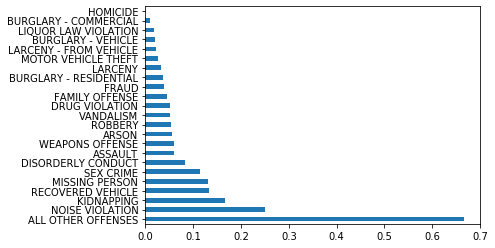

In [12]:
(missing_lat_lon['CVLEGEND'].value_counts() 
 / calls['CVLEGEND'].value_counts()
).sort_values(ascending=False).plot(kind="barh");